In [1]:
### ATOC5860 - ATOC7500_applicationlab5_ENSO_mrbutterworth
### Coded by Jennifer Kay and Elizabeth Maroon (University of Colorado)
### Last updated March 29, 2022

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio
import xarray
import pickle

In [2]:
## Read in the data.
## Data are monthly Nino3.4 sea surface temperature (SST) time series (a proxy for ENSO) from the
## CESM Large Ensemble (http://www.cesm.ucar.edu/projects/community-projects/LENS/). 
## You will analyze pre-industrial control runs that represent perpetual 1850 conditions 
## (i.e., they have constant 1850 climate).
## Note: these are the same data from Homework #4 :) Remember???
## Data are munged (preprocessed) by the NCAR CVDP package
## http://www2.cesm.ucar.edu/working_groups/CVC/cvdp//data-repository.html

fname1="CESM1_LENS_Coupled_Control.cvdp_data.401-2200.nc"
ds1=xarray.open_dataset(fname1,decode_times=False,decode_cf=False)
#ds1
data_fc=ds1["nino34"]
#print(data_fc)
nyrs=700
x=data_fc[0:12*nyrs]
    
## remove the mean (i.e., calculate the anomaly)
xa = x - np.mean(x)  

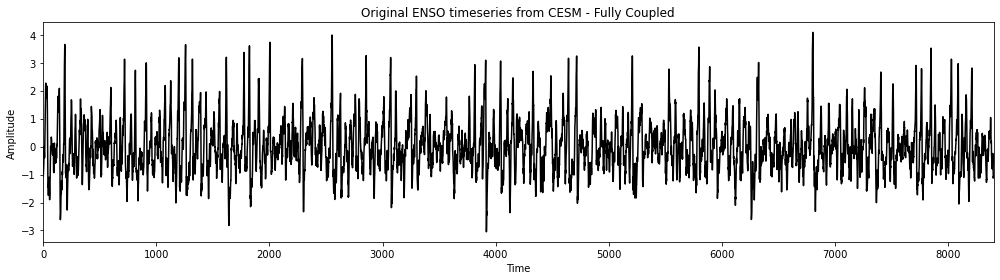

In [3]:
## Look at your data!!!
var_str = "Monthly Nino34 Anomaly"
data_units = "deg C"
f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'raw input');
plt.xlim(-1,np.size(x)+1);
plt.title('Original ENSO timeseries from CESM - Fully Coupled');
plt.xlabel('Time');
plt.ylabel('Amplitude');
f.tight_layout()

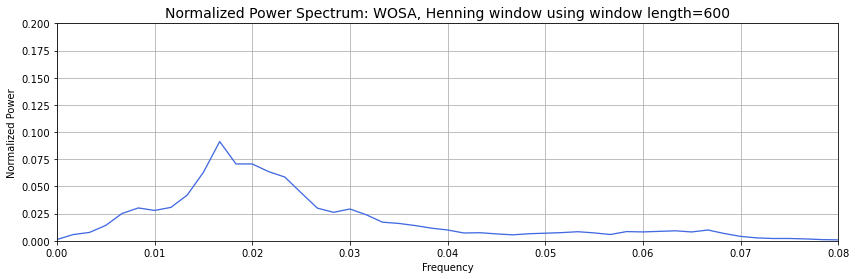

In [4]:
### Calculate the power spectrum of the original data
data=xa

## Use the Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
nyrs=50
window_length=12*nyrs
freq_w = np.arange(0.,(window_length/2)+1.)/window_length
P_welch = sig.welch(data,window='hanning',nperseg=window_length);
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize

## plot
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
plt.ylim(0.0,0.20)
plt.xlim(0.0,0.08)  
plt.grid()
plt.plot(freq_w,P_welch_n, color='royalblue', lw=1.3, label='Hanning,wl='+str(window_length));
plt.title("Normalized Power Spectrum: WOSA, Henning window using window length="+str(window_length),fontsize=14);

frequency_cutoff: 0.04
frequency_cutoff_in_years: 2.0833333333333335


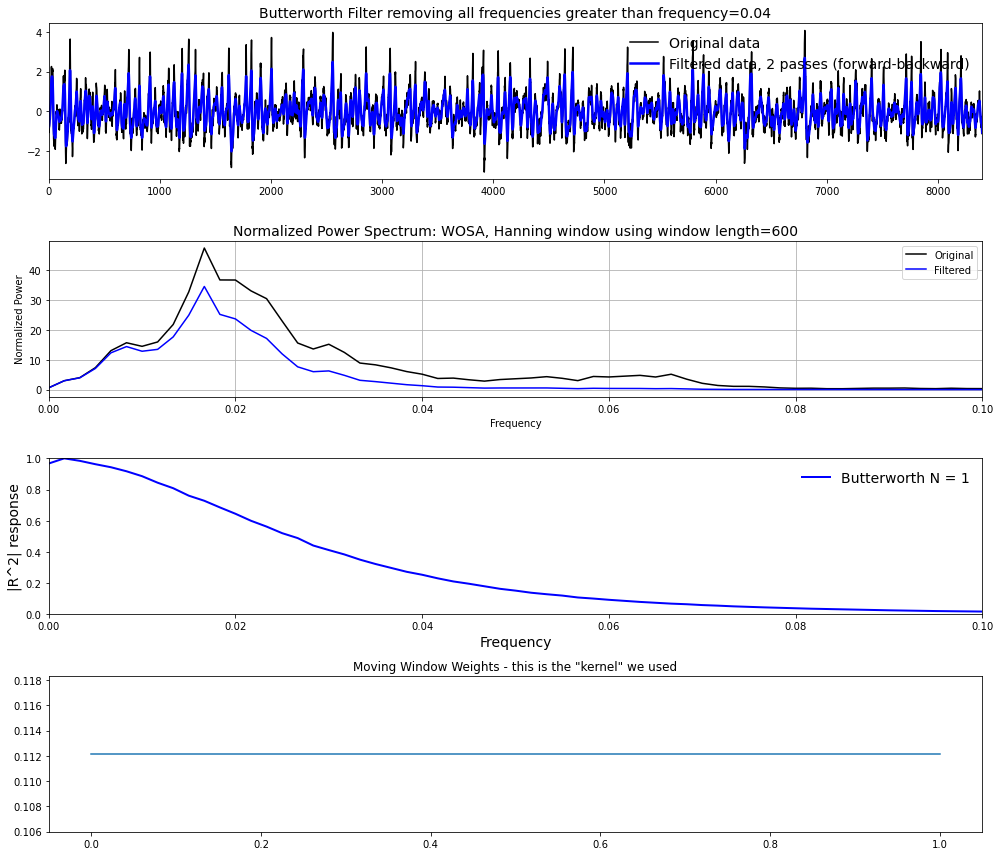

In [5]:
### Let's have some fun with the Butterworth filter (aka mrsbutterworth)
### We'll remove all frequencies greater than 0.04 (i.e., all periods shorter than 2 years).  
### We should expect the impact of this filtering to be pretty boring as there isn't a 
### lot of spectral power at high frequencies (frequencies higher than 0.04).

frequency_cutoff=0.04
frequency_cutoff_in_years=1/(frequency_cutoff*12)
print("frequency_cutoff: "+str(frequency_cutoff))
print("frequency_cutoff_in_years: "+str(frequency_cutoff_in_years))

### Apply a Butterworth filter (recursive filter) to the data
N = 1 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hanning',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency',fontsize=14);
plt.ylabel('|R^2| response',fontsize=14);
plt.legend(fontsize = 14, frameon = False);
plt.ylim(0.0,1.0);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

frequency_cutoff: 0.01
frequency_cutoff_in_years: 8.333333333333334


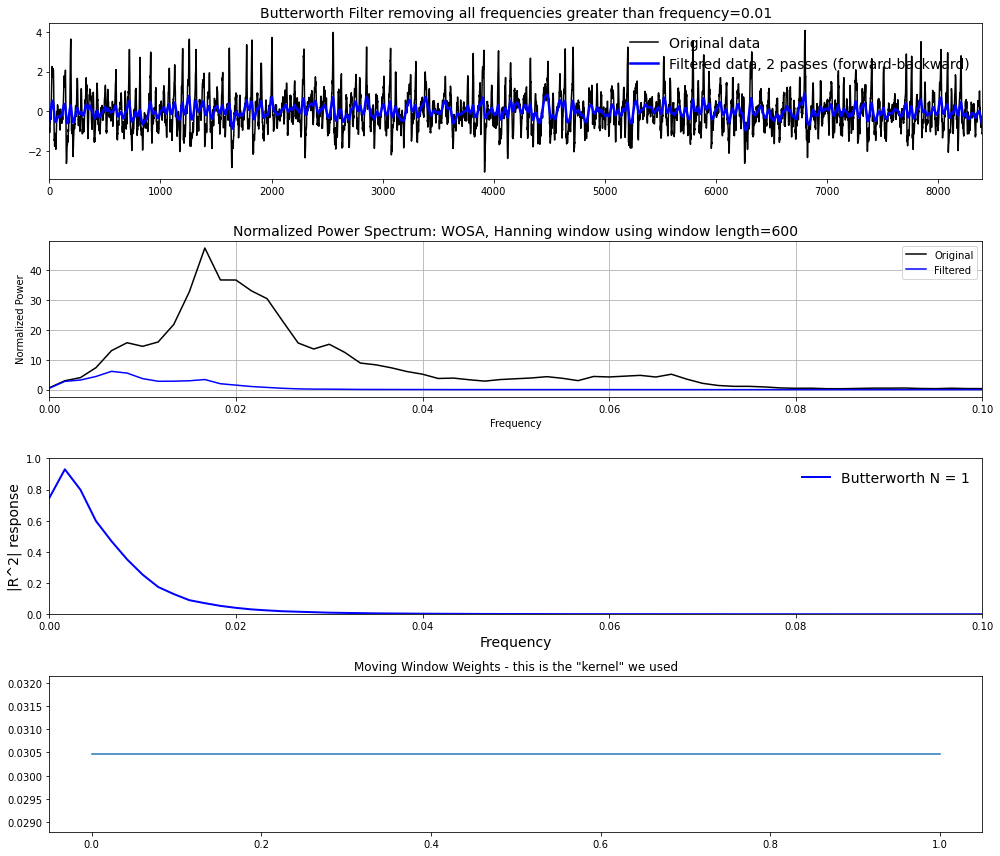

In [6]:
## Let's have some MORE fun with mrbutterworth.  We'll now remove ENSO and any sub-decadal variability
##i.e., let's remove all frequencies greater than 0.01 (shorter than 8 years)
frequency_cutoff=0.01
frequency_cutoff_in_years=1/(frequency_cutoff*12)
print("frequency_cutoff: "+str(frequency_cutoff))
print("frequency_cutoff_in_years: "+str(frequency_cutoff_in_years))

### Apply a Butterworth filter (recursive filter) to the data
N = 1 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hanning',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency',fontsize=14);
plt.ylabel('|R^2| response',fontsize=14);
plt.legend(fontsize = 14, frameon = False);
plt.ylim(0.0,1.0);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

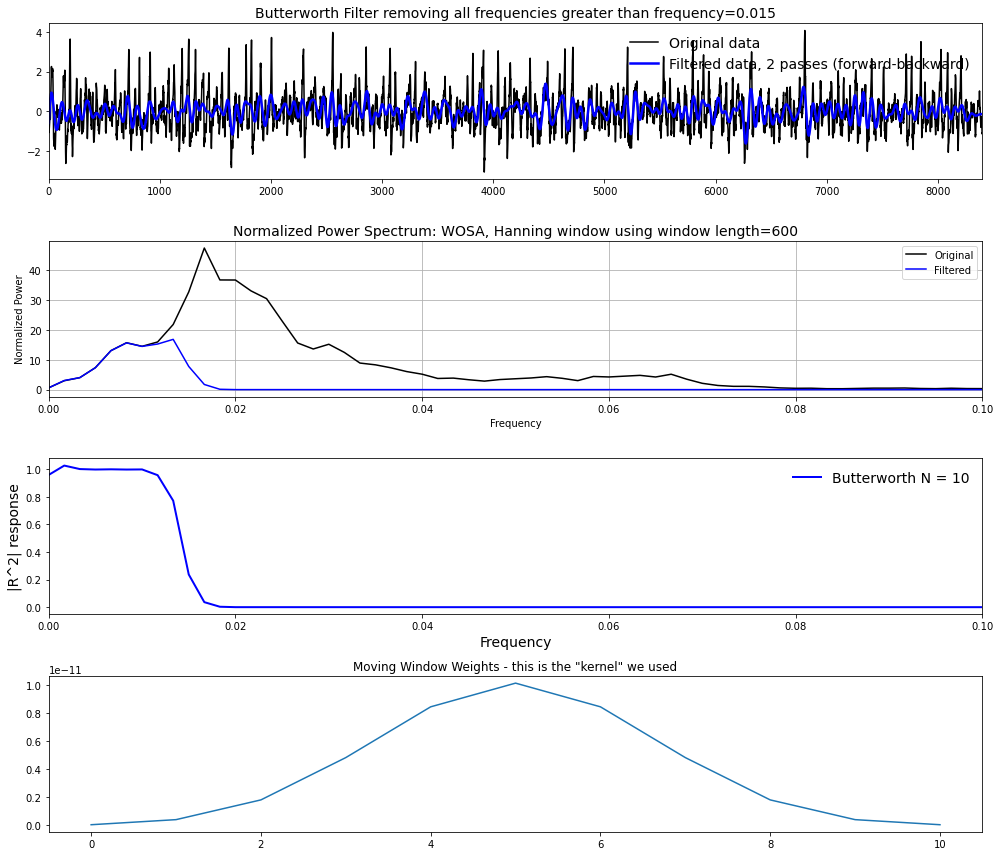

In [9]:
### Let's have some MORE fun with mrbutterworth. 
## Let's remove ENSO again but increase the number of weights in the Butterworth Filter
## Note: We should expect the cutoff in frequency space to be steeper when we use a 
## higher order Butterworth Filter (i.e., when we increase N)

frequency_cutoff=0.015
### Apply a Butterworth filter (recursive filter) to the data
N = 10 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hanning',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency',fontsize=14);
plt.ylabel('|R^2| response',fontsize=14);
plt.legend(fontsize = 14, frameon = False);
#plt.ylim(0.0,1.0);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

frequency_cutoff: 0.01
frequency_cutoff_in_years: 8.333333333333334


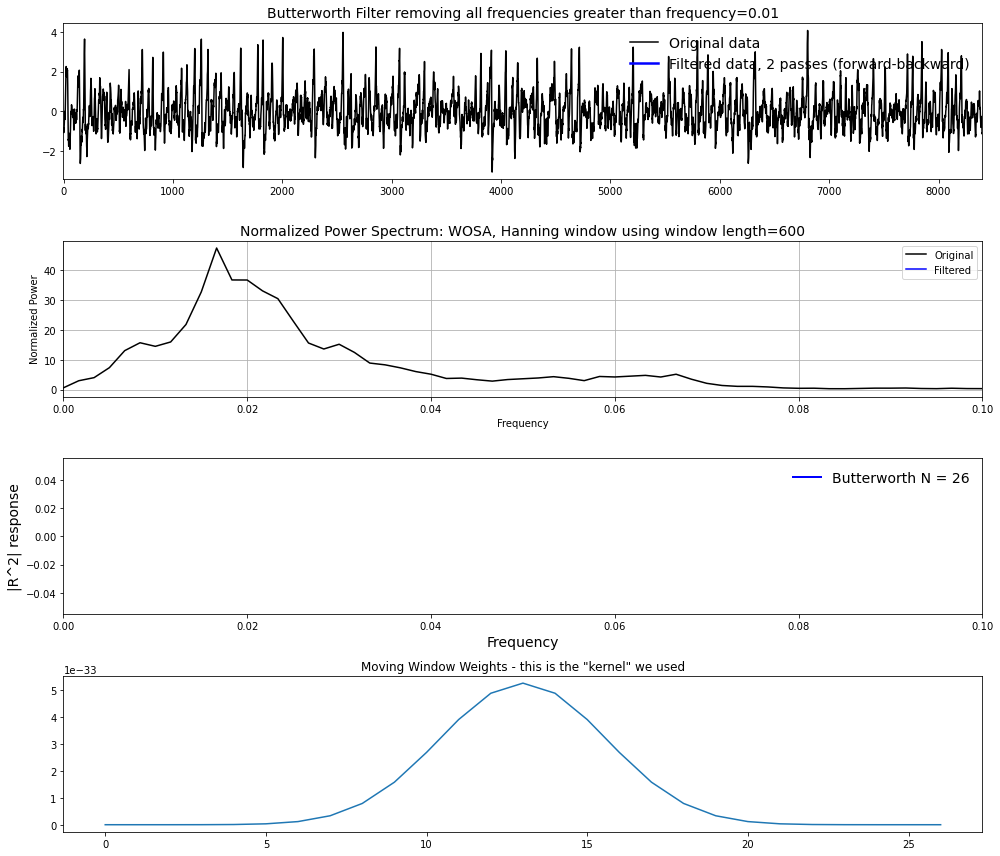

In [8]:
### Here's an example where we are starting to see the influence of the impulse function on the 
### low frequencies of the filtered dataset... ### You can only have so much tangency....

frequency_cutoff=0.01
frequency_cutoff_in_years=1/(frequency_cutoff*12)
print("frequency_cutoff: "+str(frequency_cutoff))
print("frequency_cutoff_in_years: "+str(frequency_cutoff_in_years))

### Apply a Butterworth filter (recursive filter) to the data
N = 26 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hanning',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency',fontsize=14);
plt.ylabel('|R^2| response',fontsize=14);
plt.legend(fontsize = 14, frameon = False);
#plt.ylim(0.0,1.3);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()